# 1. Реализация собственной свертки

Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
# прототип функции 
def my_conv2d(x, kernel, stride=(1, 1), padding=(0, 0), bias=None):
    B, C, H, W = x.shape
    Ck, Hk, Wk = kernel.shape

    H_out = int(1 + (H + 2 * padding[0] - Hk) / stride[0])
    W_out = int(1 + (W + 2 * padding[1] - Wk) / stride[1])
    y = torch.zeros(B, H_out, W_out)

    hs = torch.zeros(H, 1)
    ws = torch.zeros(1, W + padding[1] * 2)
    HS = torch.zeros(H, 1)
    WS = torch.zeros(1, W + padding[1] * 2)

    for i in range(padding[1] - 1):
        HS = torch.cat((HS, hs), 1)

    for i in range(padding[0] - 1):
        WS = torch.cat((WS, ws), 0)
    k = 0
    for b in x:
        conv = torch.zeros(H_out, W_out)

        for c, ck in zip(b, kernel):
            con = torch.zeros(H_out, W_out)

            if (padding[1] != 0):
                c = torch.cat((HS, c, HS), 1)
            if (padding[0] != 0):
                c = torch.cat((WS, c, WS), 0)

            for i in range(H_out):
                for j in range(W_out):
                    m = stride[0] * i
                    n = stride[1] * j
                    if c[m: m + Hk, n: n + Wk].size() == ck.size():
                        con[i, j] = sum(sum(ck * c[m: m + Hk, n: n + Wk]))
            conv += con
        y[k] = conv
        k += 1
    return y


## Тестируем функцию свертки

### Загружаем картинку 

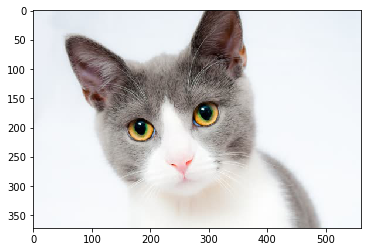

In [1]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [3]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([1, 370, 558])


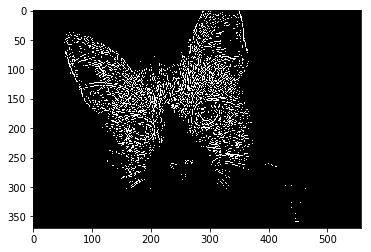

In [6]:
cat = torch.unsqueeze(cat_tensor, 0)
o_image = my_conv2d(cat, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([1, 370, 558])


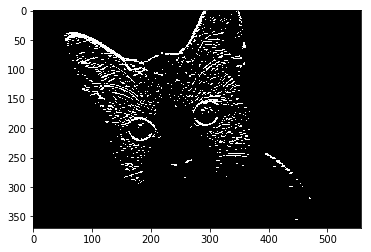

In [8]:
o_image = my_conv2d(torch.unsqueeze(cat_tensor, 0), filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [9]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([1, 370, 558])


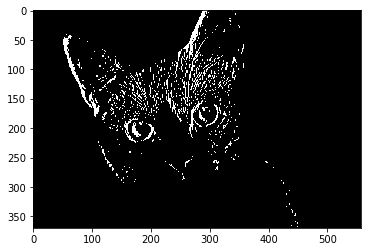

In [10]:
o_image = my_conv2d(torch.unsqueeze(cat_tensor, 0), filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([1, 186, 280])


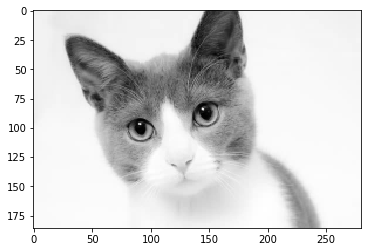

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(torch.unsqueeze(cat_tensor, 0), filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

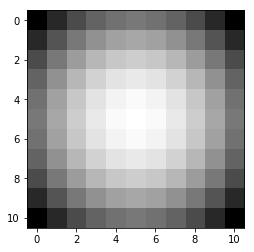

In [4]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([1, 362, 550])


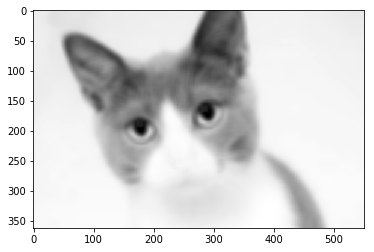

In [14]:
o_image = my_conv2d(torch.unsqueeze(cat_tensor, 0), torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image[0].numpy(), cmap='gray')

# 2. Модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [5]:
import torch
import torchvision

In [41]:
a = torch.Tensor([[[1, 2, 3, 4], [5, 6, 7, 8]], [[1, 2, 3, 4], [5, 6, 7, 8]]])
b = torch.zeros(1, 2, 1)
b[0][1][0] = 1
b[0][0][0] = 2
c = a.clone()
a -= b
print(len(a.shape))

3


In [51]:
import torch.nn as nn


class BatchNorm2d(nn.Module):
    def __init__(self, num_features, affine=True, momentum=0.9, eps=1e-8):

        super().__init__()
        self.momentum = momentum
        self.eps = eps
        self.num_features = num_features
        self.affine = affine
        self.iter = 1

    def forward(self, x):     
        mean = torch.mean(x)
        var = torch.var(x)
        
        if self.training:
            if self.iter == 1:
                self.run_mean = torch.zeros_like(mean)
                self.run_var = torch.ones_like(var)                
            self.run_mean.mul_(self.momentum).add_(1 - self.momentum, mean)
            self.run_var.mul_(self.momentum).add_(1 - self.momentum, var)
            mean, var = self.run_mean, self.run_var
            self.iter += 1
            
        x.add_(-1, mean).div_((var + self.eps) ** 0.5)
        
        if self.affine:
            for i in range(self.num_features):
                plus = torch.zeros_like(x).uniform_()
                times = torch.zeros_like(x).uniform_()
            x.mul_(times).add_(plus)

        return x

### Проверяем работу батч нормадлизации на котэ

In [52]:
cat_tensor.shape

torch.Size([3, 372, 560])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


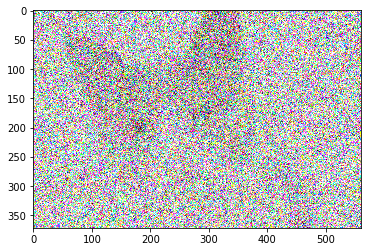

In [53]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, affine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


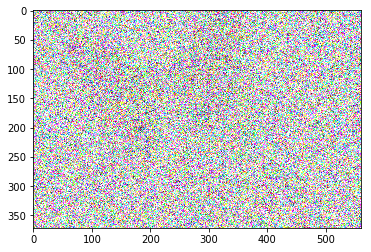

In [54]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, affine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


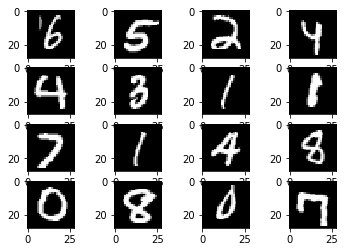

In [25]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [26]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0] // batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b * batch_size:(b + 1) * batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [np.asscalar(bn.running_mean.numpy())]
            var_curve += [np.asscalar(bn.running_var.numpy())]
    return mean_curve, var_curve


In [27]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

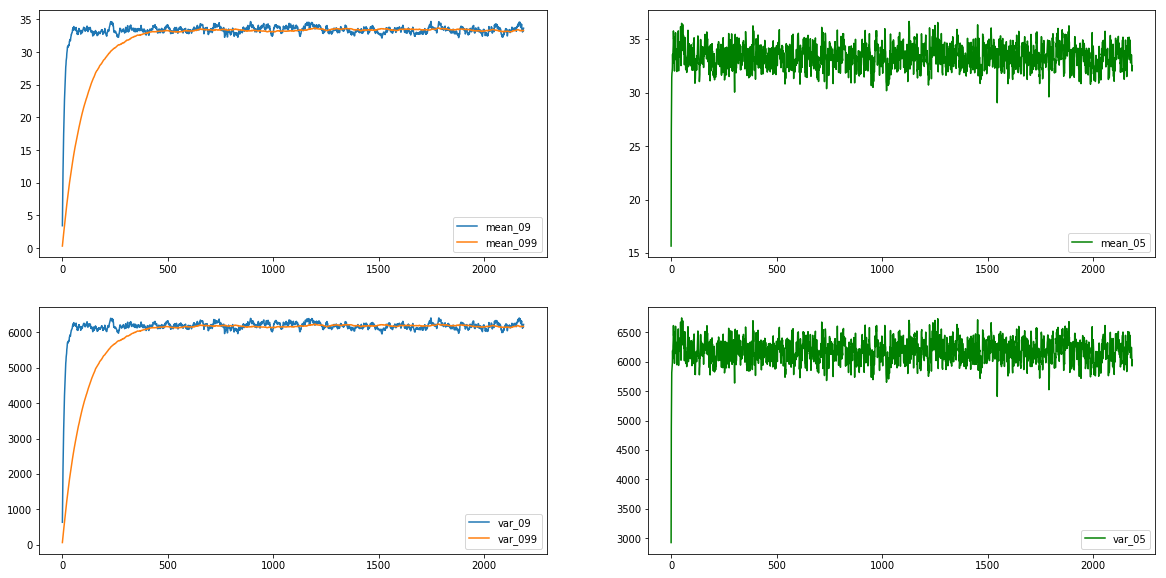

In [28]:
plt.figure(figsize=(20,10))
ax = plt.subplot(2,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

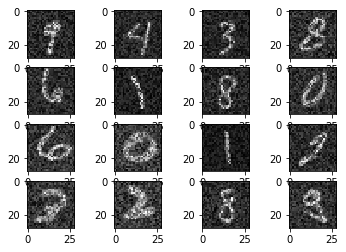

In [30]:
n=4
bn_09 = BatchNorm2d(1, beta=0.9)
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^2}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [3]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(grad)
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(grad)

                # тут можем достать сохраненные состояния
                avg, avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры.
                avg.mul_(beta1).add_(1 - beta1, grad)
                avg_sq.mul_(beta2).add_(1 - beta2, grad.mul(grad))
    
                # обновляем веса в p.data, 
                d1 = lr * avg / (1 - beta1 ** state['step'])
                d2 = (avg_sq / (1 - beta2 ** state['step']) + eps) ** 0.5
                d3 = d1.div(d2)
                p.data.add_(-1, d3) 
                
        return loss

In [4]:
t1 = torch.zeros(3,3)
t2 = torch.ones(3,3)*3
t2

NameError: name 'torch' is not defined

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [5]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    param_state = self.state[p]
                    if 'momentum' not in param_state:
                        buff = param_state['momentum'] = torch.zeros_like(p.data)
                        buff.mul_(beta).add_(grad)
                    else:
                        buff = param_state['momentum']
                        buff.mul_(beta).add_(grad.mul(1 - beta))

                # обновляем веса
                # to do
                # p.data
                p.data.add_(grad.mul(-lr))

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [6]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [7]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [9]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [56]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(20, net, optimizer) # обучаем сеть

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.10867360981362674
Do epoch 1 with loss 0.045429489174606486
Do epoch 2 with loss 0.03500242603522869
Do epoch 3 with loss 0.02902479126374908
Do epoch 4 with loss 0.025784518367005748
Do epoch 5 with loss 0.021943464745764432
Do epoch 6 with loss 0.01917452423415557
Do epoch 7 with loss 0.01788937537894709
Do epoch 8 with loss 0.01599079266933202
Do epoch 9 with loss 0.014560252686968447
Do epoch 10 with loss 0.012769960950349747
Do epoch 11 with loss 0.011449682692795733
Do epoch 12 with loss 0.011173945068495427
Do epoch 13 with loss 0.009526856308338792
Do epoch 14 with loss 0.008699598582056925
Do epoch 15 with loss 0.008766487210130494
Do epoch 16 with loss 0.008575550264755122
Do epoch 17 with loss 0.007962578172600864
Do epoch 18 with loss 0.006886502982521362
Do epoch 19 with loss 0.006370994248344411


In [57]:
learning_rate = 1e-2 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd1 = fit_net(20, net, optimizer) # обучаем сеть

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.28054762239877523
Do epoch 1 with loss 0.06805227236642541
Do epoch 2 with loss 0.05101830870335539
Do epoch 3 with loss 0.04253559157586174
Do epoch 4 with loss 0.03688017600166999
Do epoch 5 with loss 0.03282363242314295
Do epoch 6 with loss 0.029190557105632804
Do epoch 7 with loss 0.026731268951186427
Do epoch 8 with loss 0.024622713658953563
Do epoch 9 with loss 0.023030376582179487
Do epoch 10 with loss 0.021436121449330978
Do epoch 11 with loss 0.0196910302661901
Do epoch 12 with loss 0.018365108992718756
Do epoch 13 with loss 0.01700864563971608
Do epoch 14 with loss 0.016907942982558304
Do epoch 15 with loss 0.014939397518962935
Do epoch 16 with loss 0.014225318898443877
Do epoch 17 with loss 0.014022262979027993
Do epoch 18 with loss 0.012844569122595061
Do epoch 19 with loss 0.011934031218385719


In [15]:
learning_rate = 5e-3 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd2 = fit_net(20, net, optimizer) # обучаем сеть

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.9324932298433525
Do epoch 1 with loss 0.27516556104664724
Do epoch 2 with loss 0.18406733418770124
Do epoch 3 with loss 0.14646716481632546
Do epoch 4 with loss 0.12499012448878173
Do epoch 5 with loss 0.11008753970599251
Do epoch 6 with loss 0.09975136438351437
Do epoch 7 with loss 0.09130753677595572
Do epoch 8 with loss 0.0850967954065792
Do epoch 9 with loss 0.07961367676396537
Do epoch 10 with loss 0.0749854509197908
Do epoch 11 with loss 0.07106217653049854
Do epoch 12 with loss 0.06765845319521062
Do epoch 13 with loss 0.06432672612842599
Do epoch 14 with loss 0.061685238784723324
Do epoch 15 with loss 0.059365282936433054
Do epoch 16 with loss 0.05710778604114661
Do epoch 17 with loss 0.05499624783555612
Do epoch 18 with loss 0.053380597132387145
Do epoch 19 with loss 0.05184873801268123


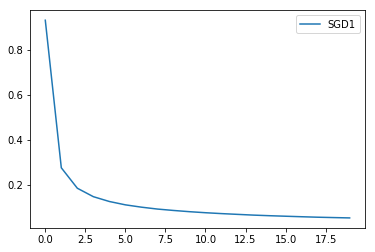

In [18]:
ax = plt.subplot(1,1,1)
# ax.plot(loss_curve_sgd1,label="SGD")
ax.plot(loss_curve_sgd2,label="SGD1")
ax.legend()

## SGD с моментом

In [24]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.10707336241421113
Do epoch 1 with loss 0.04388167880131438
Do epoch 2 with loss 0.03370133247081689
Do epoch 3 with loss 0.02846490814225773
Do epoch 4 with loss 0.024770189034077583
Do epoch 5 with loss 0.021975872884016905
Do epoch 6 with loss 0.0193975404974637
Do epoch 7 with loss 0.01800464641491899
Do epoch 8 with loss 0.014733075329060418
Do epoch 9 with loss 0.014281692416852176
Do epoch 10 with loss 0.013554127914997122
Do epoch 11 with loss 0.01268371215722961
Do epoch 12 with loss 0.011007436376131448
Do epoch 13 with loss 0.010346928540707507
Do epoch 14 with loss 0.009498496819670799
Do epoch 15 with loss 0.008162963258168116
Do epoch 16 with loss 0.008513388691097839
Do epoch 17 with loss 0.007782497816724651
Do epoch 18 with loss 0.007146642661334501
Do epoch 19 with loss 0.005292168046357591


## Adam

In [53]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.14969827438469177
Do epoch 1 with loss 0.04550276388711018
Do epoch 2 with loss 0.03415207041212016
Do epoch 3 with loss 0.02910552995222368
Do epoch 4 with loss 0.025889754142044995
Do epoch 5 with loss 0.02250930698947052
Do epoch 6 with loss 0.01991770222312956
Do epoch 7 with loss 0.017685119388007552
Do epoch 8 with loss 0.015917230991942182
Do epoch 9 with loss 0.013871572100930853
Do epoch 10 with loss 0.013730380157793173
Do epoch 11 with loss 0.01241352991680059
Do epoch 12 with loss 0.011734161704819552
Do epoch 13 with loss 0.010769690928199708
Do epoch 14 with loss 0.009758072649309718
Do epoch 15 with loss 0.009512639139060511
Do epoch 16 with loss 0.00875339455388156
Do epoch 17 with loss 0.00864462563993727
Do epoch 18 with loss 0.00796983803604965
Do epoch 19 with loss 0.00687517771505034


# Кривые обучения

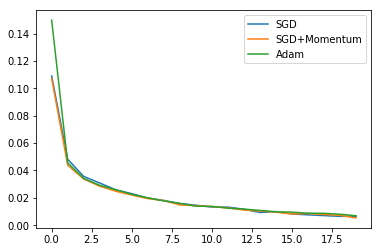

In [54]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы

Лучшее качество за 20 итераций показал SGD с моментом.

Чтобы Adam работал на равне с остальными, нужно lr выставить значительно меньше чем у SGD и SGD+Momentum(в нашем случае в 100 раз меньше)

Судя по графику Loss-ов, SGD и SGD+Momentum работают приблизительно одинаково.